In [43]:
library(ggplot2)
library(numbat)
library(dplyr)
library(glue)
library(data.table)
library(ggtree)
library(stringr)
library(tidygraph)
library(patchwork)


pat = "708"
nb = Numbat$new(out_dir = paste0('./', pat))

load(file.path(paste0("../WGS/Sarcoma708_S131_L001/Sarcoma708_S131_L001_tumor.RData")),
                wgs_env <- new.env() )

ls(wgs_env)
write.csv(wgs_env$segsS, paste0("numbat_wgs_export_files/", pat, "_wgs_segments.csv"))

[1] "altFrac"                "altFracThreshold"       "altInd"                
 [4] "binSize"                "centromere"             "chrInd"                
 [7] "chrNormalize"           "chrs"                   "chrTrain"              
[10] "chrXMedianForMale"      "cnaS"                   "compNames"             
[13] "correctedResults"       "counter"                "counts"                
[16] "coverage"               "elapsedTimeSolutions"   "estimateNormal"        
[19] "estimatePloidy"         "estimateScPrevalence"   "exons.bed"             
[22] "flankLength"            "fracAltSub"             "fracGenomeSub"         
[25] "fracReadsInChrYForMale" "gc"                     "gcWig"                 
[28] "gender"                 "gender.mismatch"        "genomeBuild"           
[31] "genomeStyle"            "hits"                   "hmmResults.cor"        
[34] "i"                      "id"                     "includeHOMD"           
[37] "iter"                   "lambda"                 "lambdaScaleHyperParam" 
[40] "libdir"                 "loglik"                 "logR"                  
[43] "logR.var"               "mainName"               "map"                   
[46] "mapWig"                 "maxBinLength"           "maxCN"                 
[49] "maxFracCNASubclone"     "maxFracGenomeSubclone"  "maxInd"                
[52] "maxSegRD"               "minMapScore"            "minSegmentBins"        
[55] "minTumFracToCorrect"    "n"                      "normal"                
[58] "normal_copy"            "normal_file"            "normal_panel"          
[61] "normalizeMaleX"         "numSamples"             "opt"                   
[64] "option_list"            "outDir"                 "outFile"               
[67] "outImage"               "outMat"                 "outPlotFile"           
[70] "p"                      "param"                  "parseobj"              
[73] "patientID"              "ploidy"                 "plotFileType"          
[76] "plotYLim"               "ptmTotalSolutions"      "results"               
[79] "s"                      "scStates"               "segAltInd"             
[82] "segsS"                  "seqinfo"                "subClonalBinCount"     
[85] "targetedSequences"      "tumour_copy"            "tumour_file"           
[88] "tumour_reads"           "txnE"                   "txnStrength"           
[91] "valid"                  "wigFiles"

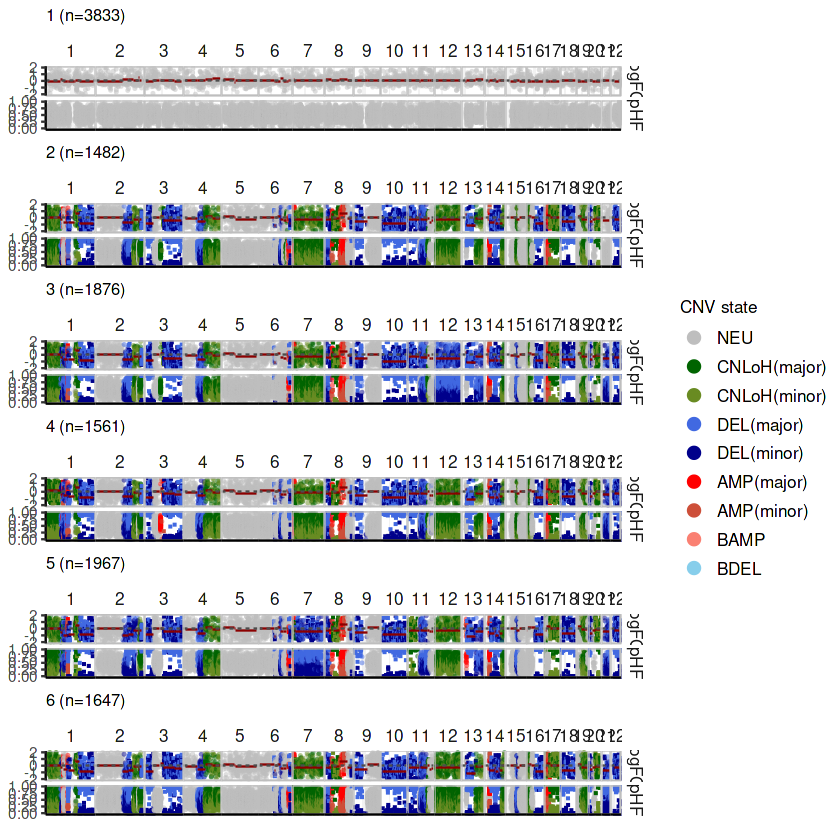

In [44]:
nb$bulk_clones %>% 
  filter(n_cells > 50) %>%
  plot_bulks(
    min_LLR = 10, # filtering CNVs by evidence
    legend = TRUE
  )

In [50]:
clone <- 1
bulk <- subset(nb$bulk_clones, sample == clone)

min_LLR = 5
min_depth = 8
exp_limit = 2
phi_mle = TRUE
theta_roll = FALSE
dot_size = 0.8
dot_alpha = 0.5
legend = TRUE
exclude_gap = TRUE
genome = 'hg38'
text_size = 10
raster = FALSE
use_pos = TRUE
allele_only = FALSE

if (!all(c('state_post', 'cnv_state_post') %in% colnames(bulk))) {
        bulk = bulk %>%
            mutate(
                state_post = state,
                cnv_state_post = cnv_state
            )
    }


# filter events by LLR
if (min_LLR != 0) {
        bulk = bulk %>% mutate(
            LLR = ifelse(is.na(LLR), 0, LLR),
            cnv_state_post = ifelse(LLR < min_LLR, 'neu', cnv_state_post),
            state_post = ifelse(LLR < min_LLR, 'neu', state_post)
        )
}

# mark clonal LOH
if ('loh' %in% colnames(bulk)) {
        ulk = bulk %>% mutate(state_post = ifelse(loh, 'del', state_post))
}

if (use_pos) {
        marker = 'POS'
        marker_label = 'Genomic position'
} else {
        marker = 'snp_index'
        marker_label = 'SNP index'
}

    # fix retest states
    bulk = bulk %>%
        mutate(
            theta_level = ifelse(str_detect(state_post, '_2'), 2, 1),
            state_post = ifelse(
                cnv_state_post %in% c('amp', 'loh', 'del'),
                ifelse(p_up > 0.5, paste0(cnv_state_post, '_', theta_level, '_', 'up'), paste0(cnv_state_post, '_', theta_level, '_', 'down')),
                state_post
        ))

    # correct for baseline bias
    if (!allele_only) {
        bulk = bulk %>% mutate(logFC = logFC - mu)
    }
   D = bulk %>%
        mutate(logFC = ifelse(logFC > exp_limit | logFC < -exp_limit, NA, logFC)) %>%
        mutate(pBAF = ifelse(DP >= min_depth, pBAF, NA)) %>%
        mutate(pHF = pBAF) %>%
        as.data.table %>%
        data.table::melt(measure.vars = c('logFC', 'pHF'))


segs = bulk %>%
distinct(CHROM, seg, seg_start, seg_start_index, seg_end, seg_end_index, phi_mle) %>%
mutate(variable = 'logFC') %>%
filter(log2(phi_mle) < exp_limit)
write.csv(segs, paste0("numbat_wgs_export_files/", pat, "/numbat",clone,"clone_segments.csv"))


write.csv(D[,c('snp_id', 'state_post','POS', "CHROM", 'POS' )] , paste0("numbat_wgs_export_files/", pat, "/numbat",clone,"clone_gene_changes.csv"))




